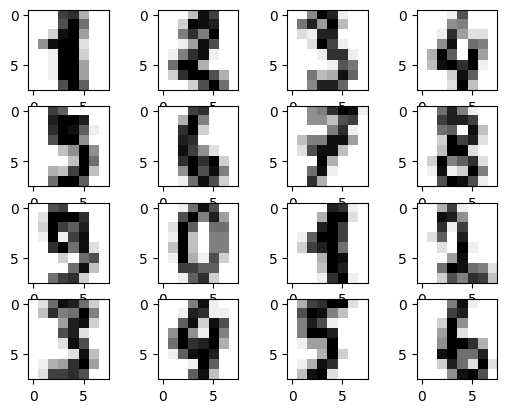

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))


Generamos un MLP sencillito para reconocimiento de numeros en MNIST

In [7]:
import torch.nn as nn
import torch

class MLP(nn.Module):
    def __init__(self, input_features, n_embeddings, n_output):
        super(MLP, self).__init__()
        self.embedding_layer = nn.Linear(input_features,n_embeddings)
        self.relu= nn.ReLU()
        self.output_layer = nn.Linear(n_embeddings,n_output)

    def embed(self,x):
        x = self.embedding_layer(x)
        x = self.relu(x)
        return x
        
    def forward(self,x):
        x = self.embed(x)
        x = self.output_layer(x)
        x = self.relu(x)
        return x

In [ ]:
from pmlb import fetch_data

# Importamos el dataset
body_fat = fetch_data('560_bodyfat')
body_fat.describe()

# Extraigo los datos (features) y los porcentajes (etiquetas a predecir)
data = body_fat.loc[:, body_fat.columns != 'target'].to_numpy()
percentages = body_fat.loc[:, body_fat.columns == 'target'].to_numpy()

data = data.astype(np.float32)

from sklearn.model_selection import train_test_split

# Particiono los datos en entrenamiento y prueba usando el método de scikitlearn
X_train, X_test, y_train, y_test = train_test_split(data , percentages , test_size=0.33, random_state=42)

from torch.utils.data import TensorDataset, DataLoader

# Tamaño del batch de entrenamiento
batch_size = 32

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 1e-3

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

mlp = MLP( 14 , 200, 1 ).to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = nn.MSELoss(reduction='mean')

# Creamos el objeto dataset que empaqueta los array de numpy para que puedan
# ser leidos por PyTorch
dataset = TensorDataset(torch.from_numpy(X_train).clone(), torch.from_numpy(y_train).clone())

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Número de épocas
num_epochs = 5000

# Lista en la que iremos guardando el valor de la función de pérdida en cada
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Realizo la pasada forward por la red
        output = mlp(x)
        loss = criterion(output, y)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

        # Acumulo la loss del minibatch
        total_loss += loss.item() * y.size(0)

    # Normalizo la loss total
    total_loss/= len(loader.dataset)

    # Muestro el valor de la función de pérdida cada 100 iteraciones
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")

In [ ]:
import autoencoder